In [5]:
# Import necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Take a glance at the provided data 

raw_data = pd.read_excel('data/dataset.xlsx', engine="openpyxl")

raw_data.info()
raw_data.describe()
raw_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5644 entries, 0 to 5643
Columns: 111 entries, Patient ID to ctO2 (arterial blood gas analysis)
dtypes: float64(70), int64(4), object(37)
memory usage: 4.8+ MB


,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,...,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.02234,-0.517413,0.010677,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d9e41465789c2b5,15,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


----

> Data Observation

The provided data contains 111 entries totally. The 3rd to 6th columns (```SARS-Cov-2 exam result```, etc) are the labels we want to predict. Other columns are features we can exploit to predict corresponding labels. However, these features look messed up now because many values of them are missing or intractable.

In [7]:
# Data preprocessing

raw_data.columns = [x.lower().strip().replace(' ','_') for x in raw_data.columns]

def show_missing_features(x):
    total = x.isnull().sum()
    percent = (x.isnull().sum()/x.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in raw_data.columns:
        dtype = str(x[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

show_missing_features(raw_data)

,patient_id,patient_age_quantile,sars-cov-2_exam_result,"patient_addmited_to_regular_ward_(1=yes,_0=no)","patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)","patient_addmited_to_intensive_care_unit_(1=yes,_0=no)",hematocrit,hemoglobin,platelets,mean_platelet_volume,...,hb_saturation_(arterial_blood_gases),pco2_(arterial_blood_gas_analysis),base_excess_(arterial_blood_gas_analysis),ph_(arterial_blood_gas_analysis),total_co2_(arterial_blood_gas_analysis),hco3_(arterial_blood_gas_analysis),po2_(arterial_blood_gas_analysis),arteiral_fio2,phosphor,cto2_(arterial_blood_gas_analysis)
Total,0,0,0,0,0,0,5041,5041,5042,5045,...,5617,5617,5617,5617,5617,5617,5617,5624,5624,5617
Percent,0.0,0.0,0.0,0.0,0.0,0.0,89.316088,89.316088,89.333806,89.38696,...,99.521616,99.521616,99.521616,99.521616,99.521616,99.521616,99.521616,99.645641,99.645641,99.521616
Types,object,int64,object,int64,int64,int64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


---

> Fill Missing Cells

From the table above, we can clearly see the data type and missing percentage of each feature. A simple approach is filling missing cells with the mean value of existing non-nan cells, or a constant. As for label-typed features, we use ```LabelEncoder```. See [sklearn.preprocessing](https://scikit-learn.org/stable/modules/preprocessing.html) for more details!

In [8]:
for x in raw_data.columns:
    # if raw_data[x].dtype == 'float':
    #     print(raw_data[x].mean())
    print(raw_data[x].dtype)

object
int64
object
int64
int64
int64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
object
object
object
object
object
object
float64
object
object
object
object
object
object
object
object
object
object
object
float64
float64
float64
float64
float64
float64
object
object
float64
float64
float64
float64
float64
float64
float64
float64
object
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
object
object
object
object
object
object
object
float64
object
object
float64
object
object
float64
object
object
object
object
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64


In [9]:
# Fill in missing features

for x in raw_data.columns:
    if raw_data[x].dtype=='float16' or  raw_data[x].dtype=='float32' or  raw_data[x].dtype=='float64':
        # raw_data[x].fillna(raw_data[x].mean())
        raw_data[x].fillna(raw_data[x].mean(skipna=True), inplace=True)

raw_data = raw_data.fillna(-999)

# Convert label-typed features
for y in raw_data.columns:
    if raw_data[y].dtype=='object': 
        lbl = LabelEncoder()
        lbl.fit(list(raw_data[y].values))
        raw_data[y] = lbl.transform(list(raw_data[y].values))

raw_data.head(10)

,patient_id,patient_age_quantile,sars-cov-2_exam_result,"patient_addmited_to_regular_ward_(1=yes,_0=no)","patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)","patient_addmited_to_intensive_care_unit_(1=yes,_0=no)",hematocrit,hemoglobin,platelets,mean_platelet_volume,...,hb_saturation_(arterial_blood_gases),pco2_(arterial_blood_gas_analysis),base_excess_(arterial_blood_gas_analysis),ph_(arterial_blood_gas_analysis),total_co2_(arterial_blood_gas_analysis),hco3_(arterial_blood_gas_analysis),po2_(arterial_blood_gas_analysis),arteiral_fio2,phosphor,cto2_(arterial_blood_gas_analysis)
0,1588,13,0,0,0,0,-2.186214e-09,-1.601319e-08,-3.535004e-10,7.438142e-09,...,-1.379737e-10,8.416397e-09,-1.655685e-09,4.139211e-10,-7.472139e-09,6.070843e-09,-2.469729e-08,4.656613e-09,6.332993e-09,5.243001e-09
1,451,17,0,0,0,0,2.365154e-01,-2.234027e-02,-5.174130e-01,1.067657e-02,...,-1.379737e-10,8.416397e-09,-1.655685e-09,4.139211e-10,-7.472139e-09,6.070843e-09,-2.469729e-08,4.656613e-09,6.332993e-09,5.243001e-09
2,3669,8,0,0,0,0,-2.186214e-09,-1.601319e-08,-3.535004e-10,7.438142e-09,...,-1.379737e-10,8.416397e-09,-1.655685e-09,4.139211e-10,-7.472139e-09,6.070843e-09,-2.469729e-08,4.656613e-09,6.332993e-09,5.243001e-09
3,5457,5,0,0,0,0,-2.186214e-09,-1.601319e-08,-3.535004e-10,7.438142e-09,...,-1.379737e-10,8.416397e-09,-1.655685e-09,4.139211e-10,-7.472139e-09,6.070843e-09,-2.469729e-08,4.656613e-09,6.332993e-09,5.243001e-09
4,4843,15,0,0,0,0,-2.186214e-09,-1.601319e-08,-3.535004e-10,7.438142e-09,...,-1.379737e-10,8.416397e-09,-1.655685e-09,4.139211e-10,-7.472139e-09,6.070843e-09,-2.469729e-08,4.656613e-09,6.332993e-09,5.243001e-09
5,2665,9,0,0,0,0,-2.186214e-09,-1.601319e-08,-3.535004e-10,7.438142e-09,...,-1.379737e-10,8.416397e-09,-1.655685e-09,4.139211e-10,-7.472139e-09,6.070843e-09,-2.469729e-08,4.656613e-09,6.332993e-09,5.243001e-09
6,1008,13,0,0,0,0,-2.186214e-09,-1.601319e-08,-3.535004e-10,7.438142e-09,...,-1.379737e-10,8.416397e-09,-1.655685e-09,4.139211e-10,-7.472139e-09,6.070843e-09,-2.469729e-08,4.656613e-09,6.332993e-09,5.243001e-09
7,1832,16,0,0,0,0,-2.186214e-09,-1.601319e-08,-3.535004e-10,7.438142e-09,...,-1.379737e-10,8.416397e-09,-1.655685e-09,4.139211e-10,-7.472139e-09,6.070843e-09,-2.469729e-08,4.656613e-09,6.332993e-09,5.243001e-09
8,3121,1,0,0,1,0,-1.571682e+00,-7.742120e-01,1.429667e+00,-1.672222e+00,...,-1.379737e-10,8.416397e-09,-1.655685e-09,4.139211e-10,-7.472139e-09,6.070843e-09,-2.469729e-08,4.656613e-09,7.303929e-01,5.243001e-09
9,2186,17,0,0,0,0,-2.186214e-09,-1.601319e-08,-3.535004e-10,7.438142e-09,...,-1.379737e-10,8.416397e-09,-1.655685e-09,4.139211e-10,-7.472139e-09,6.070843e-09,-2.469729e-08,4.656613e-09,6.332993e-09,5.243001e-09


---

> Feature Engineering

Feature engineering is always the most time-consuming and energy-consuming part of data analysis. And it is not a deterministic step like algorithms and models, but more about engineering experience and trade-offs. 

Here we provide a simple intuition to select useful features: we calculate the correlations between each feature as the covariance matrix, and then remove the features highly correlated with others (which means this column can be easily linear-combined by others). 

In [11]:
# Calculate the covariance matrix

corr_matrix = raw_data.corr().abs()
corr_matrix.head()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,patient_id,patient_age_quantile,sars-cov-2_exam_result,"patient_addmited_to_regular_ward_(1=yes,_0=no)","patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)","patient_addmited_to_intensive_care_unit_(1=yes,_0=no)",hematocrit,hemoglobin,platelets,mean_platelet_volume,...,hb_saturation_(arterial_blood_gases),pco2_(arterial_blood_gas_analysis),base_excess_(arterial_blood_gas_analysis),ph_(arterial_blood_gas_analysis),total_co2_(arterial_blood_gas_analysis),hco3_(arterial_blood_gas_analysis),po2_(arterial_blood_gas_analysis),arteiral_fio2,phosphor,cto2_(arterial_blood_gas_analysis)
patient_id,NaN,0.014136,0.018664,0.003748,0.004803,0.000162,0.020071,0.014706,0.006948,0.008635,...,0.011604,0.011653,0.002840,0.010472,0.005338,0.004317,0.005510,0.021115,5.294190e-03,0.003037
patient_age_quantile,NaN,NaN,0.075244,0.046166,0.015736,0.035772,0.031292,0.019498,0.051183,0.038392,...,0.016286,0.034110,0.041484,0.041507,0.006264,0.012090,0.007157,0.021239,4.135060e-02,0.004455
sars-cov-2_exam_result,NaN,NaN,NaN,0.142437,0.019364,0.027586,0.037396,0.039530,0.106482,0.040622,...,0.015189,0.037511,0.015111,0.036451,0.028879,0.024761,0.036186,0.030815,5.314858e-03,0.030967
"patient_addmited_to_regular_ward_(1=yes,_0=no)",NaN,NaN,NaN,NaN,0.011264,0.010192,0.071569,0.075363,0.150186,0.010687,...,0.051133,0.058510,0.008632,0.052540,0.041230,0.034427,0.027247,0.040326,1.377290e-18,0.070462
"patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)",NaN,NaN,NaN,NaN,NaN,0.008087,0.161800,0.157295,0.006185,0.020840,...,0.199293,0.040333,0.080640,0.063793,0.040144,0.048656,0.120723,0.025106,5.392442e-02,0.017481


In [12]:
threshold = 0.92
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))
dataset = raw_data.drop(columns = to_drop) # dropped data
print('Data shape: ', raw_data.shape)
print('Size of the cleaned data', dataset.shape)

There are 28 columns to remove.
Data shape:  (5644, 111)
Size of the cleaned data (5644, 83)


In [13]:
# Dataset contains selected features

dataset.info(verbose=False)
dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5644 entries, 0 to 5643
Columns: 83 entries, patient_id to cto2_(arterial_blood_gas_analysis)
dtypes: float64(66), int32(13), int64(4)
memory usage: 3.3 MB


,patient_id,patient_age_quantile,sars-cov-2_exam_result,"patient_addmited_to_regular_ward_(1=yes,_0=no)","patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)","patient_addmited_to_intensive_care_unit_(1=yes,_0=no)",hematocrit,platelets,mean_platelet_volume,red_blood_cells,...,d-dimer,albumin,hb_saturation_(arterial_blood_gases),pco2_(arterial_blood_gas_analysis),base_excess_(arterial_blood_gas_analysis),total_co2_(arterial_blood_gas_analysis),po2_(arterial_blood_gas_analysis),arteiral_fio2,phosphor,cto2_(arterial_blood_gas_analysis)
0,1588,13,0,0,0,0,-2.186214e-09,-3.535004e-10,7.438142e-09,8.424447e-09,...,-999.0,-5.731216e-09,-1.379737e-10,8.416397e-09,-1.655685e-09,-7.472139e-09,-2.469729e-08,4.656613e-09,6.332993e-09,5.243001e-09
1,451,17,0,0,0,0,2.365154e-01,-5.174130e-01,1.067657e-02,1.020042e-01,...,-999.0,-5.731216e-09,-1.379737e-10,8.416397e-09,-1.655685e-09,-7.472139e-09,-2.469729e-08,4.656613e-09,6.332993e-09,5.243001e-09
2,3669,8,0,0,0,0,-2.186214e-09,-3.535004e-10,7.438142e-09,8.424447e-09,...,-999.0,-5.731216e-09,-1.379737e-10,8.416397e-09,-1.655685e-09,-7.472139e-09,-2.469729e-08,4.656613e-09,6.332993e-09,5.243001e-09
3,5457,5,0,0,0,0,-2.186214e-09,-3.535004e-10,7.438142e-09,8.424447e-09,...,-999.0,-5.731216e-09,-1.379737e-10,8.416397e-09,-1.655685e-09,-7.472139e-09,-2.469729e-08,4.656613e-09,6.332993e-09,5.243001e-09
4,4843,15,0,0,0,0,-2.186214e-09,-3.535004e-10,7.438142e-09,8.424447e-09,...,-999.0,-5.731216e-09,-1.379737e-10,8.416397e-09,-1.655685e-09,-7.472139e-09,-2.469729e-08,4.656613e-09,6.332993e-09,5.243001e-09


---

> **TODO**

**Try to Select or Create Meanful Features from ```raw_data```.**

For example, try dimensionality reduction methods like [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) or [NMF](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization#:~:text=Non-negative) or [Tree-Based models](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.tree) to weight feature's importance. These tools can be easily found in [scikit-learn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition). But it is more encouraged for you to understand the principle behind them and implement them by yourself.

> Requirements
* Conduct feature engineering by using [scikit-learn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition) or your own implementation.
* Compare the final test results obtained by your method in your report. 
* Note that you should first read through and complete other parts of this notebook so that you can start for comparison.

In [151]:
label_col = ['patient_id','sars-cov-2_exam_result', 'patient_addmited_to_regular_ward_(1=yes,_0=no)', 'patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)', 'patient_addmited_to_intensive_care_unit_(1=yes,_0=no)']
cols = [x for x in raw_data.columns if x not in label_col] # These columns are the features we can use to predict

"""
PCA实现-numpy
""" 
# 映射的特征维度
k = 100

# 1.标准化 去除均值
raw_data[cols] = raw_data[cols] - raw_data[cols].mean()

# 2.计算协方差矩阵
cov_matrix = raw_data[cols].cov().abs().to_numpy()

# 3.求协方差矩阵的特征根和特征向量
eigen_vals, eigen_vecs = np.linalg.eig(cov_matrix)

# 4.选取主要成分:特征值前k大的特征向量对应的新空间
eigen_val_inds = np.argsort(np.abs(eigen_vals))[-1-k:-1]
W = eigen_vecs[:, eigen_val_inds]
# W = eigen_vecs
dataset_PCA = np.dot(raw_data[cols].to_numpy(), W)

In [14]:
"""
PCA实现 sklearn
"""

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# 对原始数据PCA
# label_col = ['patient_id','sars-cov-2_exam_result', 'patient_addmited_to_regular_ward_(1=yes,_0=no)', 'patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)', 'patient_addmited_to_intensive_care_unit_(1=yes,_0=no)']
# rd_cols = [x for x in raw_data.columns if x not in label_col] # These columns are the features we can use to predict

# raw_data_scale = MinMaxScaler().fit_transform(raw_data[rd_cols].to_numpy())
# raw_data_std = StandardScaler().fit_transform(raw_data_scale)

# dataset_prepsc = pd.DataFrame(PCA().fit_transform(raw_data_std))
# dataset_prepsc = pd.DataFrame(raw_data_std)

# dataset_prepsc.head()

label_col = ['patient_id','sars-cov-2_exam_result', 'patient_addmited_to_regular_ward_(1=yes,_0=no)', 'patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)', 'patient_addmited_to_intensive_care_unit_(1=yes,_0=no)']
ds_cols = [x for x in dataset.columns if x not in label_col] # These columns are the features we can use to predict

dataset_scale = MinMaxScaler().fit_transform(dataset[ds_cols].to_numpy())
dataset_std = StandardScaler().fit_transform(dataset_scale)

dataset_prepsc = pd.DataFrame(PCA().fit_transform(dataset_std))
# dataset_prepsc = pd.DataFrame(raw_data_std)

dataset_prepsc.head()

,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,77
0,-0.257237,0.146488,-0.034294,0.023786,-0.030312,-0.017538,0.054862,0.041972,-0.025122,0.039402,...,-0.000358,-0.000633,-7.278503e-10,-3.465243e-16,-2.425843e-16,-8.449894e-17,1.175873e-16,9.437726e-17,1.956406e-16,-1.929831e-16
1,0.327901,1.869794,-3.347866,0.772605,-1.388803,-1.462476,1.271801,1.029630,-2.819498,2.393101,...,-0.043498,-0.005081,1.413390e-08,-3.559393e-16,-3.508210e-16,3.031916e-17,-6.285510e-16,-1.623521e-16,-2.821878e-17,-3.098317e-16
2,-0.271449,0.095707,0.011489,0.018311,-0.031859,0.012230,0.001193,0.076568,-0.020402,0.042467,...,0.000168,-0.000342,-2.086537e-10,8.192379e-17,2.225413e-16,-2.200860e-17,2.303344e-16,-2.180132e-16,6.786127e-17,2.042732e-16
3,-0.279976,0.065238,0.038958,0.015026,-0.032787,0.030091,-0.031009,0.097326,-0.017570,0.044306,...,0.000483,-0.000167,1.028691e-10,-5.080571e-17,2.702672e-16,-3.812924e-17,1.483021e-16,-5.755235e-16,1.490300e-16,2.703930e-16
4,-0.171364,0.146342,-0.033713,0.000824,0.069736,-0.073495,0.087756,-0.063447,-0.008501,-0.055613,...,-0.003302,0.001000,-3.571450e-10,5.327558e-16,7.018677e-17,3.237241e-17,5.698946e-16,1.023418e-15,-1.718372e-16,2.829932e-18


---

> Create Dataset and Split Train/Test Data

The following part builds up our dataset and split them into Train/Test Splits.

In [15]:
label_col = ['patient_id','sars-cov-2_exam_result', 'patient_addmited_to_regular_ward_(1=yes,_0=no)', 'patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)', 'patient_addmited_to_intensive_care_unit_(1=yes,_0=no)']
cols = [x for x in dataset.columns if x not in label_col] # These columns are the features we can use to predict

In [16]:
X = dataset[cols]
# X = dataset_prepsc
X.head()

,patient_age_quantile,hematocrit,platelets,mean_platelet_volume,red_blood_cells,lymphocytes,mean_corpuscular_hemoglobin_concentration (mchc),leukocytes,basophils,mean_corpuscular_hemoglobin_(mch),...,d-dimer,albumin,hb_saturation_(arterial_blood_gases),pco2_(arterial_blood_gas_analysis),base_excess_(arterial_blood_gas_analysis),total_co2_(arterial_blood_gas_analysis),po2_(arterial_blood_gas_analysis),arteiral_fio2,phosphor,cto2_(arterial_blood_gas_analysis)
0,13,-2.186214e-09,-3.535004e-10,7.438142e-09,8.424447e-09,-7.866736e-09,1.014863e-09,6.215833e-09,-6.633739e-09,-3.453010e-09,...,-999.0,-5.731216e-09,-1.379737e-10,8.416397e-09,-1.655685e-09,-7.472139e-09,-2.469729e-08,4.656613e-09,6.332993e-09,5.243001e-09
1,17,2.365154e-01,-5.174130e-01,1.067657e-02,1.020042e-01,3.183658e-01,-9.507903e-01,-9.461035e-02,-2.237665e-01,-2.922693e-01,...,-999.0,-5.731216e-09,-1.379737e-10,8.416397e-09,-1.655685e-09,-7.472139e-09,-2.469729e-08,4.656613e-09,6.332993e-09,5.243001e-09
2,8,-2.186214e-09,-3.535004e-10,7.438142e-09,8.424447e-09,-7.866736e-09,1.014863e-09,6.215833e-09,-6.633739e-09,-3.453010e-09,...,-999.0,-5.731216e-09,-1.379737e-10,8.416397e-09,-1.655685e-09,-7.472139e-09,-2.469729e-08,4.656613e-09,6.332993e-09,5.243001e-09
3,5,-2.186214e-09,-3.535004e-10,7.438142e-09,8.424447e-09,-7.866736e-09,1.014863e-09,6.215833e-09,-6.633739e-09,-3.453010e-09,...,-999.0,-5.731216e-09,-1.379737e-10,8.416397e-09,-1.655685e-09,-7.472139e-09,-2.469729e-08,4.656613e-09,6.332993e-09,5.243001e-09
4,15,-2.186214e-09,-3.535004e-10,7.438142e-09,8.424447e-09,-7.866736e-09,1.014863e-09,6.215833e-09,-6.633739e-09,-3.453010e-09,...,-999.0,-5.731216e-09,-1.379737e-10,8.416397e-09,-1.655685e-09,-7.472139e-09,-2.469729e-08,4.656613e-09,6.332993e-09,5.243001e-09


In [17]:
y = raw_data['sars-cov-2_exam_result'] # predict ```sars-cov-2_exam_result``` (Negative/Positive)

# random split to Train/Test with the ratio of 2:1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=101) # fixed random seed
X_train.head()

,patient_age_quantile,hematocrit,platelets,mean_platelet_volume,red_blood_cells,lymphocytes,mean_corpuscular_hemoglobin_concentration (mchc),leukocytes,basophils,mean_corpuscular_hemoglobin_(mch),...,d-dimer,albumin,hb_saturation_(arterial_blood_gases),pco2_(arterial_blood_gas_analysis),base_excess_(arterial_blood_gas_analysis),total_co2_(arterial_blood_gas_analysis),po2_(arterial_blood_gas_analysis),arteiral_fio2,phosphor,cto2_(arterial_blood_gas_analysis)
5248,17,-5.874738e-01,-7.937728e-01,3.472554e-01,-3.916462e-01,-7.397033e-02,3.437252e-01,-9.350135e-01,-1.140144e+00,-1.354549e-01,...,-999.0,-5.731216e-09,-1.379737e-10,8.416397e-09,-1.655685e-09,-7.472139e-09,-2.469729e-08,4.656613e-09,6.332993e-09,5.243001e-09
2253,11,-2.186214e-09,-3.535004e-10,7.438142e-09,8.424447e-09,-7.866736e-09,1.014863e-09,6.215833e-09,-6.633739e-09,-3.453010e-09,...,-999.0,-5.731216e-09,-1.379737e-10,8.416397e-09,-1.655685e-09,-7.472139e-09,-2.469729e-08,4.656613e-09,6.332993e-09,5.243001e-09
1394,6,-2.186214e-09,-3.535004e-10,7.438142e-09,8.424447e-09,-7.866736e-09,1.014863e-09,6.215833e-09,-6.633739e-09,-3.453010e-09,...,-999.0,-5.731216e-09,-1.379737e-10,8.416397e-09,-1.655685e-09,-7.472139e-09,-2.469729e-08,4.656613e-09,6.332993e-09,5.243001e-09
2662,7,-2.186214e-09,-3.535004e-10,7.438142e-09,8.424447e-09,-7.866736e-09,1.014863e-09,6.215833e-09,-6.633739e-09,-3.453010e-09,...,-999.0,-5.731216e-09,-1.379737e-10,8.416397e-09,-1.655685e-09,-7.472139e-09,-2.469729e-08,4.656613e-09,6.332993e-09,5.243001e-09
2784,1,-2.186214e-09,-3.535004e-10,7.438142e-09,8.424447e-09,-7.866736e-09,1.014863e-09,6.215833e-09,-6.633739e-09,-3.453010e-09,...,-999.0,-5.731216e-09,-1.379737e-10,8.416397e-09,-1.655685e-09,-7.472139e-09,-2.469729e-08,4.656613e-09,6.332993e-09,5.243001e-09


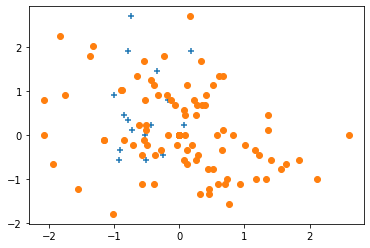

In [18]:
# view  train data
v_num = 1000
pos_slice = y_train[0:v_num]==1
neg_slice = y_train[0:v_num]==0
pos_x = X_train.to_numpy()[0:v_num][pos_slice][:, 2:4]
neg_x = X_train.to_numpy()[0:v_num][neg_slice][:, 2:4]

# print(pos_x[:,0])

plt.scatter(pos_x[:,0],pos_x[:,1],marker='+')
plt.scatter(neg_x[:,0],neg_x[:,1],marker='o')
plt.show()

---

> **TODO**

**Select and Train Your Model on ```X_train``` and ```y_train```**

We provide an example of ```LogisticRegression``` and ```DecisionTreeClassifier```. Now it's time for your to select the model you like to conduct classification.

> Requirements
* Select at least **three** other Machine Learning models and train them on the Train split. And you should implement at least **one** by yourself.

In [19]:
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, roc_curve, auc

def evaluate_model(model, name, print_or_not:bool = True, need_fit = False):
    performance = {}
    
    # cv_acc = 0
    if name == 'K Nearest Neighbors' or name == 'Random Forest' or 'Decision Tree' or need_fit:
        model.fit(X_train, y_train)
    else:
        cv_acc = cross_val_score(lg, X_train, y_train, scoring='accuracy')
        # print(cv_acc)
        # cv_acc = cv_acc.mean()
        # performance['cv_accuracy'] = cv_acc
    prds = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, prds)
    performance['accuracy'] = accuracy
    
    conf_mat = confusion_matrix(y_test, prds)
    performance['confusion_matrix'] = conf_mat
    
    
    precision_sc = precision_score(y_test, prds)
    performance['precision_score'] = precision_sc
    
    
    recall_sc = recall_score(y_test, prds)
    performance['recall_score'] = recall_sc
    
    f1_sc = f1_score(y_test, prds)
    performance['f1_score'] = f1_sc
    
    if print_or_not == True:
        print(f'evaluation of {name}:')
        # print(f'Cross Validation\'s Accuracy of {name}: {cv_acc}')
        
        print(f'Accuracy of {name}: {accuracy}')
        print(f'Confussion Matrix of {name}:\n{conf_mat}')
        print(f"Precision score of {name}: {precision_sc}")
        print(f"Recall score of {name}: {recall_sc}")
        print(f"F1 score of {name}: {f1_sc}")
    
        fpr, tpr, threshold = roc_curve(y_test, prds)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6,6))
        plt.title('Validation ROC')
        plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        
    return performance
    
# evaluate_model(tree, "Decision Tree")

In [134]:
accuracy_lst =[]

def model_assess(model, name='Default'):
    model.fit(X_train, y_train)
    prds = model.predict(X_test)
    model_acc = accuracy_score(y_test, prds)
    accuracy_lst.append(100*model_acc)
    print('Accuracy:', (accuracy_score(y_test, prds)), '\n')
    
def model_assess_get_acc(model, name='Default'):
    model.fit(X_train, y_train)
    prds = model.predict(X_test)
    # model_acc = accuracy_score(y_test, prds)
    print('Accuracy:', (accuracy_score(y_test, prds)), '\n')
    return accuracy_score

In [365]:
# naive model - all negative
from sklearn.base import BaseEstimator

class negative_model(BaseEstimator):
    def __init__(self):
        pass
    
    def fit(self, x_train, y_train):
        pass
    
    def predict(self, x_test):
        return np.zeros(shape = x_test.shape[0], dtype='int32')
    
neg_model = negative_model()
model_assess(neg_model, 'all_nagetive')

Accuracy: 0.90552871712292 



evaluation of Logistic Regression:
Accuracy of Logistic Regression: 0.571658615136876
Confussion Matrix of Logistic Regression:
[[952 735]
 [ 63 113]]
Precision score of Logistic Regression: 0.1332547169811321
Recall score of Logistic Regression: 0.6420454545454546
F1 score of Logistic Regression: 0.220703125


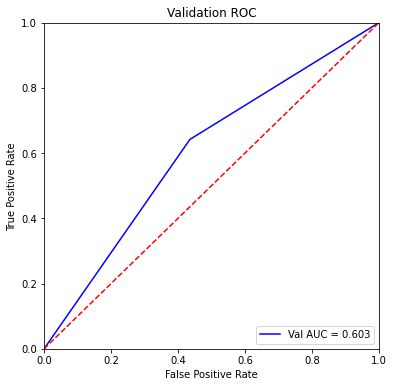

{'accuracy': 0.571658615136876,
 'confusion_matrix': array([[952, 735],
        [ 63, 113]], dtype=int64),
 'precision_score': 0.1332547169811321,
 'recall_score': 0.6420454545454546,
 'f1_score': 0.220703125}

In [135]:
# Logistic Regression
lg = LogisticRegression(class_weight='balanced')
evaluate_model(lg, 'Logistic Regression')

evaluation of Decision Tree:
Accuracy of Decision Tree: 0.8996242619431025
Confussion Matrix of Decision Tree:
[[1665   22]
 [ 165   11]]
Precision score of Decision Tree: 0.3333333333333333
Recall score of Decision Tree: 0.0625
F1 score of Decision Tree: 0.10526315789473684


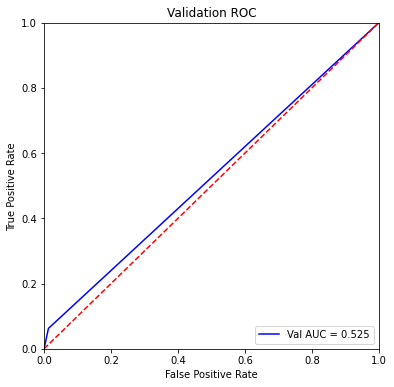

In [138]:
tree = DecisionTreeClassifier()
pf = evaluate_model(tree, 'Decision Tree')

In [ ]:
# Decision Tree
from sklearn.model_selection import GridSearchCV

param_sel = {}
param_sel['max_depth'] = np.arange(5,15,1)
param_sel['min_samples_leaf'] = np.arange(1, 5, 1)
param_sel['class_weights'] = [{1:x, 0:1} for x in np.arange(8, 15, 1)]
# param_sel = {'max_depth' = np.arange(5,15,1), 'min_samples_leaf' = np.arange(1, 5, 1), 'class_weights' = [{1:x, 0:1} for x in np.arange(8, 15, 1)] }
tree_sel =  GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_sel, scoring=f1_score)
tree_sel.fit(X_train, y_test)
tree_sel.best_estimator_

In [173]:
# k-Nearest-Neighbour

max_k = 0
max_acc = 0
max_f1 = 0
for i in np.arange(4,10, 1, dtype='int32'):
    knn_test = neighbors.KNeighborsClassifier(n_neighbors=i, p = 2)
    print(f"k = {i}")
    knn_test.fit(X_train, y_train)
    prds = knn_test.predict(X_test)
    model_acc = accuracy_score(y_test, prds)
    f1_sc = f1_score(y_test, prds)
    # if model_acc > max_acc:
    #     max_k = i
    #     max_acc = model_acc
    if f1_sc > max_f1:
        max_k = i
        max_f1 = f1_sc
        
print(f'max_k:{max_k}')
print(f"F1_score: {max_f1}")

kNN_model = neighbors.KNeighborsClassifier(n_neighbors=max_k, p=2)

k = 4
k = 5
k = 6
k = 7
k = 8
k = 9
max_k:6
F1_score: 0.02247191011235955


evaluation of K Nearest Neighbors:
Accuracy of K Nearest Neighbors: 0.9066022544283414
Confussion Matrix of K Nearest Neighbors:
[[1687    0]
 [ 174    2]]
Precision score of K Nearest Neighbors: 1.0
Recall score of K Nearest Neighbors: 0.011363636363636364
F1 score of K Nearest Neighbors: 0.02247191011235955


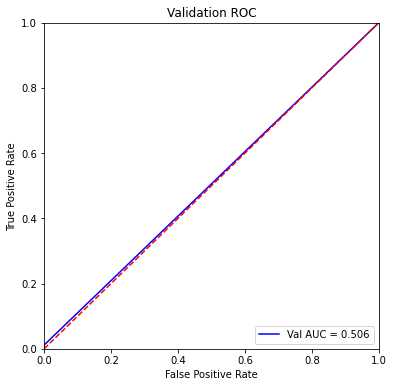

{'accuracy': 0.9066022544283414,
 'confusion_matrix': array([[1687,    0],
        [ 174,    2]], dtype=int64),
 'precision_score': 1.0,
 'recall_score': 0.011363636363636364,
 'f1_score': 0.02247191011235955}

In [174]:
evaluate_model(kNN_model, 'K Nearest Neighbors', need_fit=True)

In [140]:
# kernel SVM
from sklearn.svm import SVC

SVM_model = SVC()
model_assess(SVM_model, 'SVM')

Accuracy: 0.90552871712292 



In [372]:
# MLP
from sklearn.neural_network import MLPClassifier

MLP_model = MLPClassifier(solver='sgd', learning_rate_init=0.1, alpha=1e-5, max_iter=1000, hidden_layer_sizes=(5, 10,), random_state=1)
model_assess(MLP_model, "MLP")

Accuracy: 0.9028448738593666 



evaluation of RF:
Accuracy of RF: 0.90552871712292
Confussion Matrix of RF:
[[1683    4]
 [ 172    4]]
Precision score of RF: 0.5
Recall score of RF: 0.022727272727272728
F1 score of RF: 0.04347826086956522


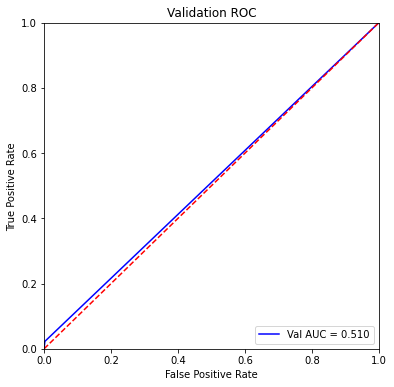

In [160]:
# RF
from sklearn.ensemble import RandomForestClassifier

RF_model = RandomForestClassifier(n_estimators=200)
pf = evaluate_model(RF_model, "RF")

evaluation of My Classifier:
Accuracy of My Classifier: 0.7960279119699409
Confussion Matrix of My Classifier:
[[1448  239]
 [ 141   35]]
Precision score of My Classifier: 0.12773722627737227
Recall score of My Classifier: 0.19886363636363635
F1 score of My Classifier: 0.15555555555555556


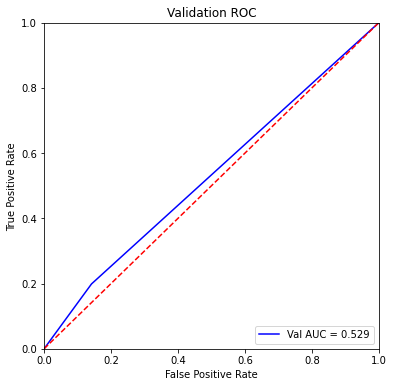

{'accuracy': 0.7960279119699409,
 'confusion_matrix': array([[1448,  239],
        [ 141,   35]], dtype=int64),
 'precision_score': 0.12773722627737227,
 'recall_score': 0.19886363636363635,
 'f1_score': 0.15555555555555556}

In [33]:
# My classifier
from sklearn.base import BaseEstimator
from scipy.spatial import cKDTree

class MyClassifier(BaseEstimator):
    
    def __init__(self, k=5):
        self.k = k

    def fit(self, X_tr, y_tr):
        self.X = X_tr
        self.y = y_tr
        self._data = cKDTree(self.X.to_numpy())
        
    def predict(self, X_te):
        y_pred = []
        for i in range(len(X_te)):
            dist, idx = self._data.query(X_te.to_numpy()[i], k=self.k)
            y_pred.append(self._vote(ys=self.y.to_numpy()[idx]))
        return np.array(y_pred)

    def _square_distance(self, v1, v2):
        return np.sum(np.square(v1-v2))

    def _vote(self, ys):
        neg_num = np.sum(ys==1)
        if neg_num > 15:
            return 1
        else:
            return 0

evaluate_model(MyClassifier(100), name='My Classifier', need_fit=True)


evaluation of Naive_Bayes:
Accuracy of Naive_Bayes: 0.1492216854535695
Confussion Matrix of Naive_Bayes:
[[ 115 1572]
 [  13  163]]
Precision score of Naive_Bayes: 0.09394812680115273
Recall score of Naive_Bayes: 0.9261363636363636
F1 score of Naive_Bayes: 0.1705913134484563


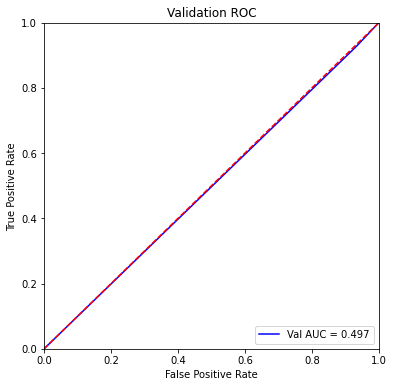

{'accuracy': 0.1492216854535695,
 'confusion_matrix': array([[ 115, 1572],
        [  13,  163]], dtype=int64),
 'precision_score': 0.09394812680115273,
 'recall_score': 0.9261363636363636,
 'f1_score': 0.1705913134484563}

In [159]:
# GuassianDB
from sklearn.naive_bayes import GaussianNB
NB_model = GaussianNB()
evaluate_model(NB_model, 'Naive_Bayes', need_fit=True )

In [ ]:
# Demostrate model results on Train split

model_list = ['Logistic Regression', 'DT']

plt.rcParams['figure.figsize']=4,4
sns.set_style('darkgrid')
ax = sns.barplot(x=model_list, y = accuracy_lst, palette = "coolwarm", saturation =2.0)
plt.xlabel('Classifier Models', fontsize = 12)
plt.ylabel('% of Accuracy', fontsize = 12)
plt.title('Accuracy(PCA, n=106)', fontsize = 16)
plt.xticks(fontsize = 12, horizontalalignment = 'center')
plt.yticks(fontsize = 12)
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy() 
    ax.annotate(f'{round(height,2)}%', (x + width/2, y + height), ha='center', fontsize = 'x-large')
plt.savefig("figures/LR_DT_Accuracy_PCA_n_106")
plt.show()


In [160]:
# Cross-validaiton

cross_acc = []

ca_lg = cross_val_score(lg, X_train, y_train, scoring='accuracy')
ca_lg = ca_lg.mean()
cross_acc.append(100*ca_lg)

ca_tree = cross_val_score(tree, X_train, y_train, scoring='accuracy')
ca_tree = ca_tree.mean()
cross_acc.append(100*ca_tree)

In [ ]:
# Demostrate model results on Test split

plt.rcParams['figure.figsize']=4,4
sns.set_style('darkgrid')
ax = sns.barplot(x=model_list, y=cross_acc, palette = "rocket", saturation =2.0)
plt.xlabel('Classifier Models', fontsize = 12 )
plt.ylabel('Cross validation Accuracy', fontsize = 12)
plt.title('Accuracy of different Classifier Models', fontsize = 16)
plt.xticks(fontsize = 12, horizontalalignment = 'center')
plt.yticks(fontsize = 12)
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy() 
    ax.annotate(f'{round(height,2)}%', (x + width/2, y + height), ha='center', fontsize = 'x-large')
    
plt.savefig("figures/LR_DT_Accuracy_version_0_cross_valid")
plt.show()

---

> **TODO**

**Tune Model for Good Performance on Test Split**

The final objective for training is to obtain a model that performs well on the unseen Test split (not to overfit the Train split). Now it is your time to provide the final solution.

> Requirements
* Try more evaluation methods (like Confusion Matrix, AUC curve and etc.) to make your results more convincing.
* Tune model's hyperparameters by cross-validation and evaluate all your selected models. And give a detailed report on the performance and computational efficiency.
* It is appreciated if other machine learning techniques that help to improve performance are employed.

In [217]:
# cross validation
def cross_valid(model):
    ca = cross_val_score(model, X_train, y_train, scoring='accuracy')
    ca = ca.mean()
    return cross_acc

In [72]:
# evaluation model
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, roc_curve, auc

def evaluate_model(model, name, print_or_not:bool = True, need_fit = False):
    performance = {}
    
    # cv_acc = 0
    if name == 'K Nearest Neighbors' or name == 'Random Forest' or 'Decision Tree' or need_fit:
        model.fit(X_train, y_train)
    else:
        cv_acc = cross_val_score(lg, X_train, y_train, scoring='accuracy')
        # print(cv_acc)
        # cv_acc = cv_acc.mean()
        # performance['cv_accuracy'] = cv_acc
    prds = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, prds)
    performance['accuracy'] = accuracy
    
    conf_mat = confusion_matrix(y_test, prds)
    performance['confusion_matrix'] = conf_mat
    
    
    precision_sc = precision_score(y_test, prds)
    performance['precision_score'] = precision_sc
    
    
    recall_sc = recall_score(y_test, prds)
    performance['recall_score'] = recall_sc
    
    f1_sc = f1_score(y_test, prds)
    performance['f1_score'] = f1_sc
    
    if print_or_not == True:
        print(f'evaluation of {name}:')
        # print(f'Cross Validation\'s Accuracy of {name}: {cv_acc}')
        
        print(f'Accuracy of {name}: {accuracy}')
        print(f'Confussion Matrix of {name}:\n{conf_mat}')
        print(f"Precision score of {name}: {precision_sc}")
        print(f"Recall score of {name}: {recall_sc}")
        print(f"F1 score of {name}: {f1_sc}")
    
        fpr, tpr, threshold = roc_curve(y_test, prds)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6,6))
        plt.title('Validation ROC')
        plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        
    return performance
    
# evaluate_model(tree, "Decision Tree")
    

In [413]:
# tune hyperparam of DT

# max_f1 = 0
# max_dep, max_minleaf = 0, 0
# for depth in np.arange(1, 10, 1):
#     for min_leaf in range(1, 10, 1):
#         tree_test = DecisionTreeClassifier(criterion='gini', min_samples_leaf=min_leaf, max_depth=depth)
#         pf = evaluate_model(tree_test, 'Decision Tree', print_or_not=False)
#         if pf['f1_score']  > max_f1:
#             max_dep, max_minleaf = depth, min_leaf
#             max_f1 = pf['f1_score']

# print(f"max_f1:{max_f1} max_param:({max_dep}, {max_minleaf})")       

max_f1 = 0
max_w = k
for depth in np.arange(2, 8, 1):
    for min_leaf in range(1, 3, 1):
        for i in np.arange(5, 16, 1):
            class_w = {1:i, 0:1}
            tree_test = DecisionTreeClassifier(criterion='gini', class_weight= class_w)
            pf = evaluate_model(tree_test, 'Decision Tree', print_or_not=False)
            if pf['f1_score']  > max_f1:
                max_w = i
                max_dep, max_minleaf = depth, min_leaf   
                max_f1 = pf['f1_score']

print(f"max_f1:{max_f1} max_param:({max_w})")    
        

max_f1:0.21480406386066764 max_param:(15)


evaluation of All Negative:
Accuracy of All Negative: 0.90552871712292
Confussion Matrix of All Negative:[[1687    0]
 [ 176    0]]
Precision score of All Negative: 0.0
Recall score of All Negative: 0.0
F1 score of All Negative: 0.0


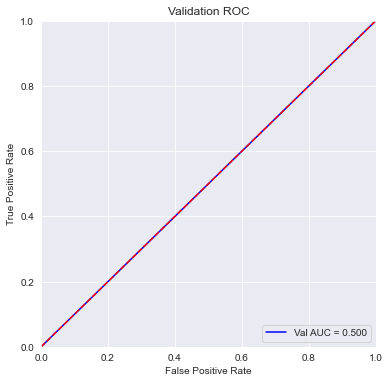

evaluation of Logistic Regression:
Accuracy of Logistic Regression: 0.9071390230810521
Confussion Matrix of Logistic Regression:[[1676   11]
 [ 162   14]]
Precision score of Logistic Regression: 0.56
Recall score of Logistic Regression: 0.07954545454545454
F1 score of Logistic Regression: 0.13930348258706465


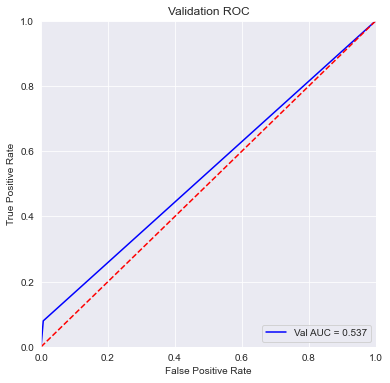

evaluation of Decision Tree:
Accuracy of Decision Tree: 0.9066022544283414
Confussion Matrix of Decision Tree:[[1677   10]
 [ 164   12]]
Precision score of Decision Tree: 0.5454545454545454
Recall score of Decision Tree: 0.06818181818181818
F1 score of Decision Tree: 0.12121212121212122


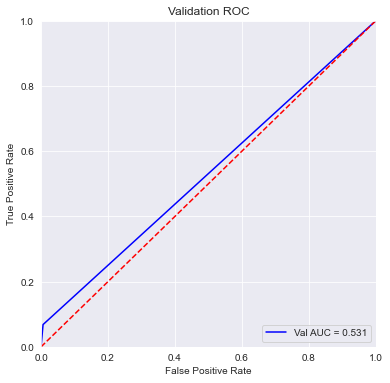

evaluation of K Nearest Neighbors:
Accuracy of K Nearest Neighbors: 0.9066022544283414
Confussion Matrix of K Nearest Neighbors:[[1687    0]
 [ 174    2]]
Precision score of K Nearest Neighbors: 1.0
Recall score of K Nearest Neighbors: 0.011363636363636364
F1 score of K Nearest Neighbors: 0.02247191011235955


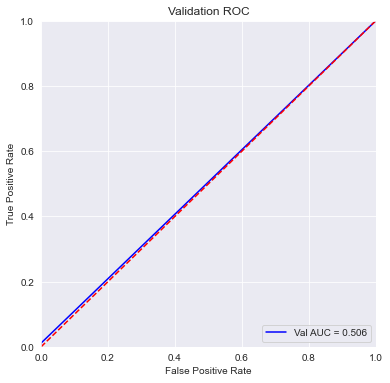

evaluation of Support Vector Machine:
Accuracy of Support Vector Machine: 0.9060654857756307
Confussion Matrix of Support Vector Machine:[[1687    0]
 [ 175    1]]
Precision score of Support Vector Machine: 1.0
Recall score of Support Vector Machine: 0.005681818181818182
F1 score of Support Vector Machine: 0.01129943502824859


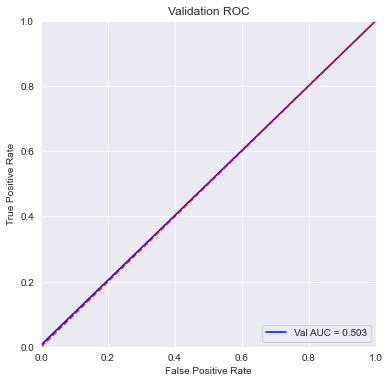

evaluation of Multiple Layer Perception:
Accuracy of Multiple Layer Perception: 0.9028448738593666
Confussion Matrix of Multiple Layer Perception:[[1670   17]
 [ 164   12]]
Precision score of Multiple Layer Perception: 0.41379310344827586
Recall score of Multiple Layer Perception: 0.06818181818181818
F1 score of Multiple Layer Perception: 0.11707317073170731


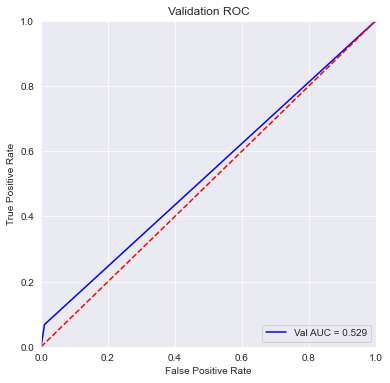

evaluation of Random Forest:
Accuracy of Random Forest: 0.9060654857756307
Confussion Matrix of Random Forest:[[1682    5]
 [ 170    6]]
Precision score of Random Forest: 0.5454545454545454
Recall score of Random Forest: 0.03409090909090909
F1 score of Random Forest: 0.0641711229946524


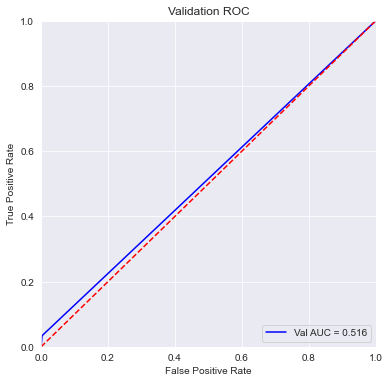

In [395]:
models = [neg_model, lg, tree, kNN_model, SVM_model, MLP_model, RF_model]
model_names = ["All Negative", "Logistic Regression", "Decision Tree", "K Nearest Neighbors", "Support Vector Machine", "Multiple Layer Perception", "Random Forest"]
n_models = 7

for i in range(7):
    evaluate_model(models[i], model_names[i])

---

> **TODO**

**Try to Predict for Another Task**

Now, your are familiar with the simple pipeline of data mining. The final task for you is to explore the ```data/dataset.xlsx``` to predict one of the labels above:
* ```patient_addmited_to_regular_ward_(1=yes,_0=no)```
* ```patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)```
* ```patient_addmited_to_intensive_care_unit_(1=yes,_0=no)```

> Requirements
* Use **Row 5001-5645** of ```data/dataset.xlsx``` as the Test Split. Write code or a jupyter notebook to show how you solve this task. Please give detailed comments of your code and a good demonstration of your results.


---